<a href="https://colab.research.google.com/github/haminhtien99/cvr_course/blob/main/mnist_sem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация рукописных цифр [2]: свёрточные сети

MNIST - датасет из 60000+10000 одноканальных изображений 28x28

Измените среду выполнения на GPU

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



tensor(4)


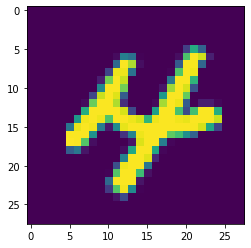

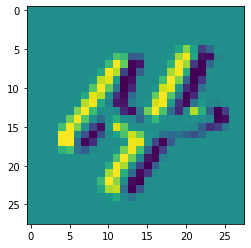

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print (target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

        #kernel = np.ones((3, 3),np.float32)
        kernel = np.array([[-1, 0, 1]],np.float32)

        #print (type (img))
        convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
        plt.imshow (convolved)
        plt.show ()

    break

In [4]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

# def test(model, device, test_loader, loss_archive):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss = test_loss / len(test_loader)
#     loss_archive.append (test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293846
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.492722
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.563258
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.488181
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302157
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.315815
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.383990
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.156034
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164482
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.424047
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.307674
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.170113


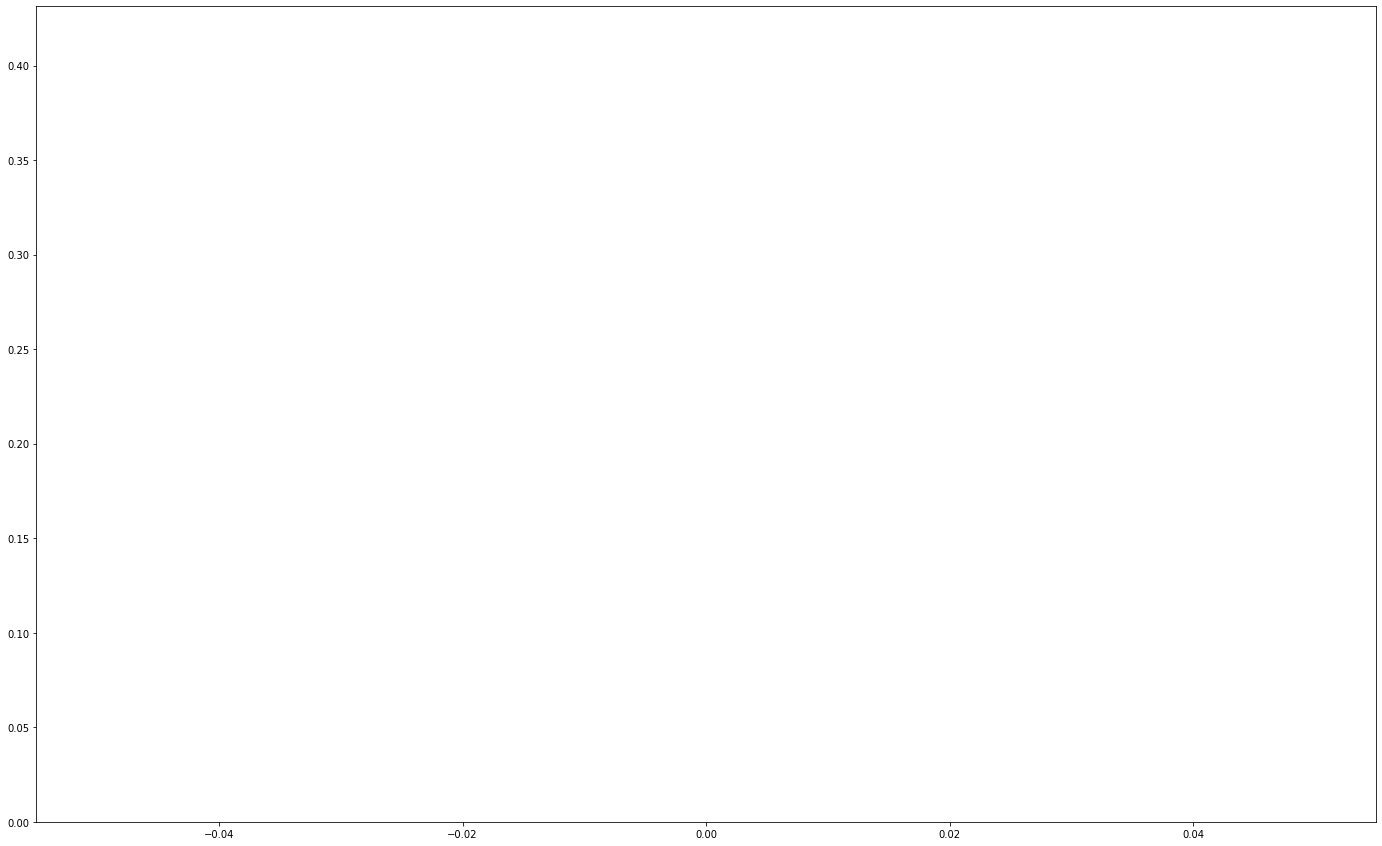

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.170807
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.089949
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.155378
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.253948
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.163699
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.256382
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.201383
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.237717
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112954
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.065763
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.134348
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.120420


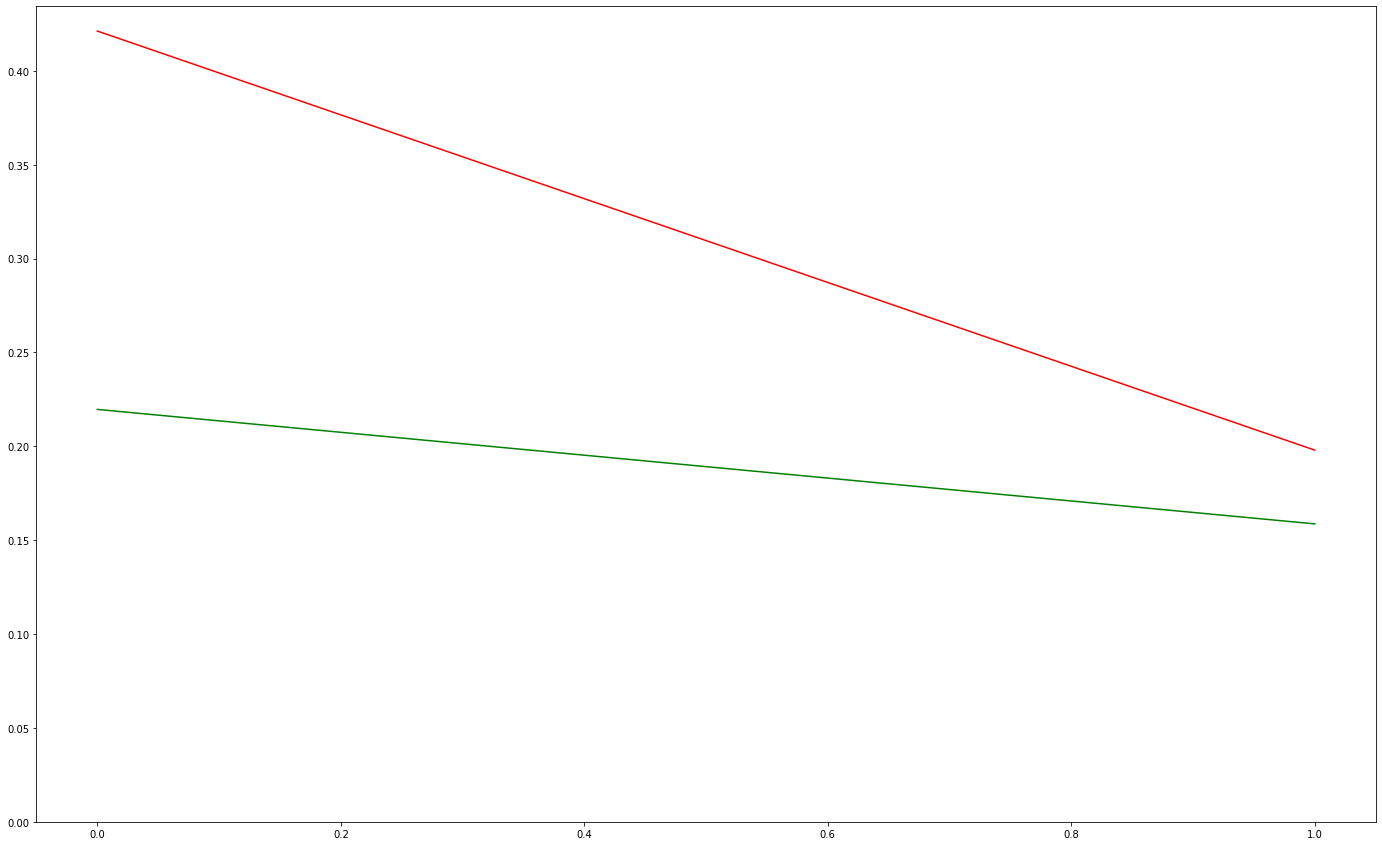

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168488
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.074072
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.133433
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.182287
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.101397
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.208466
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.196928
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.108029
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.126268
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.113561
Train Epoch: 3 [0/10000 (0%)]	Loss: 0.081205
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.115125


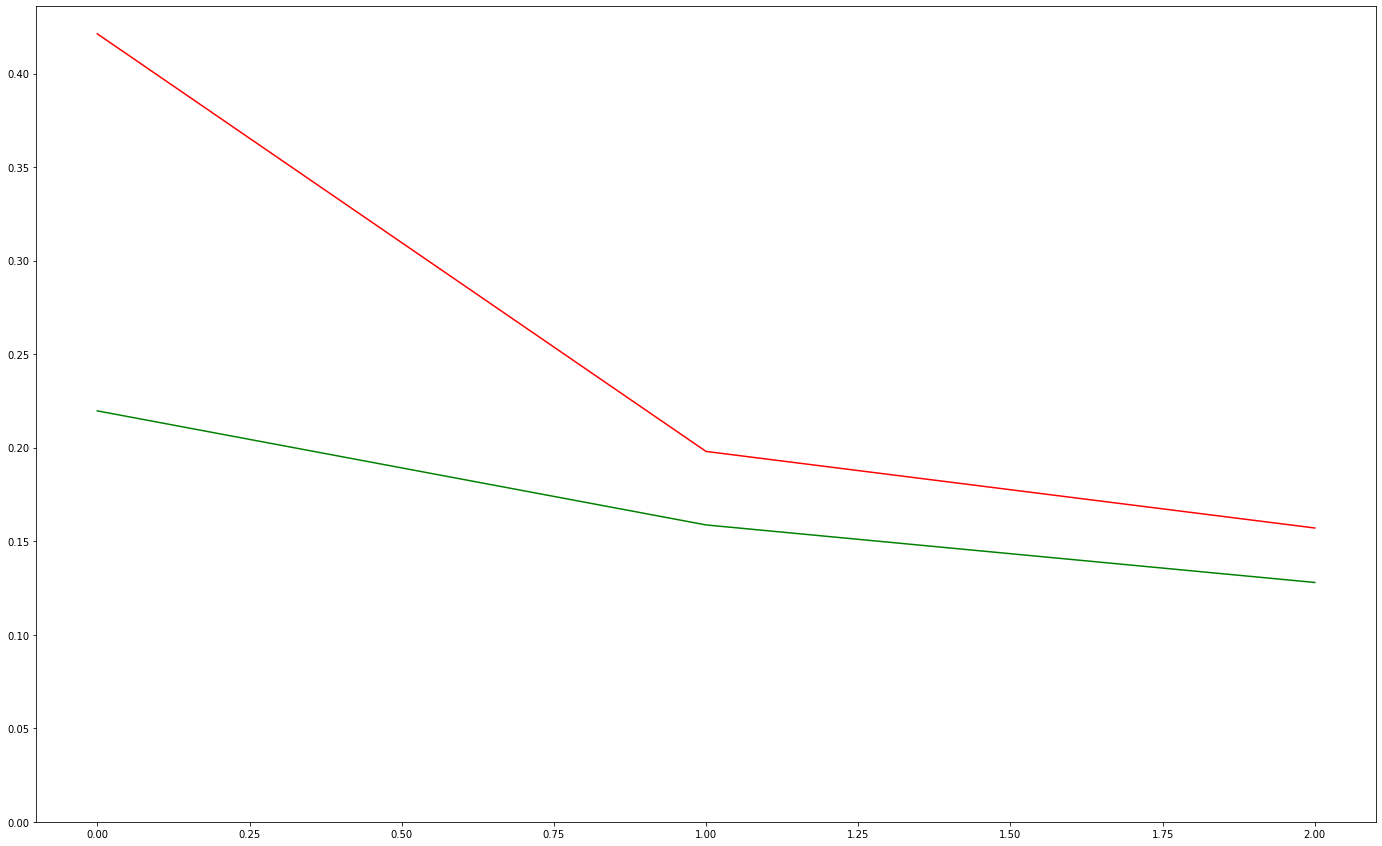

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.090644
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.071572
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.161608
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.134186
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.046396
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.106329
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.144186
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.231537
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.085781
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.048228
Train Epoch: 4 [0/10000 (0%)]	Loss: 0.126591
Train Epoch: 4 [6400/10000 (64%)]	Loss: 0.107456


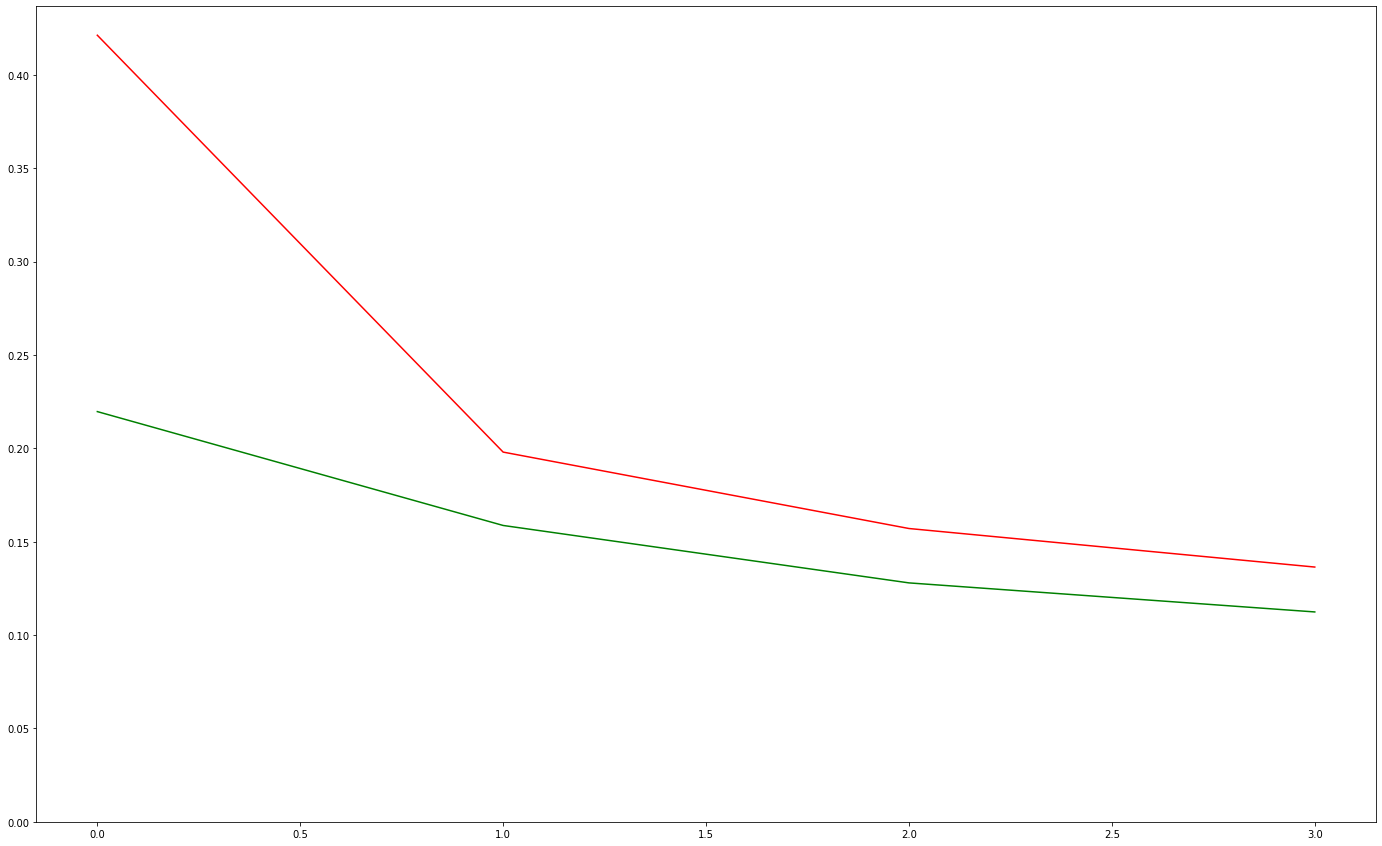

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.265002
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.081496
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.090681
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.107221
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.145944
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.095239
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.212408
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.137610
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.095599
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.046789
Train Epoch: 5 [0/10000 (0%)]	Loss: 0.117661
Train Epoch: 5 [6400/10000 (64%)]	Loss: 0.046292


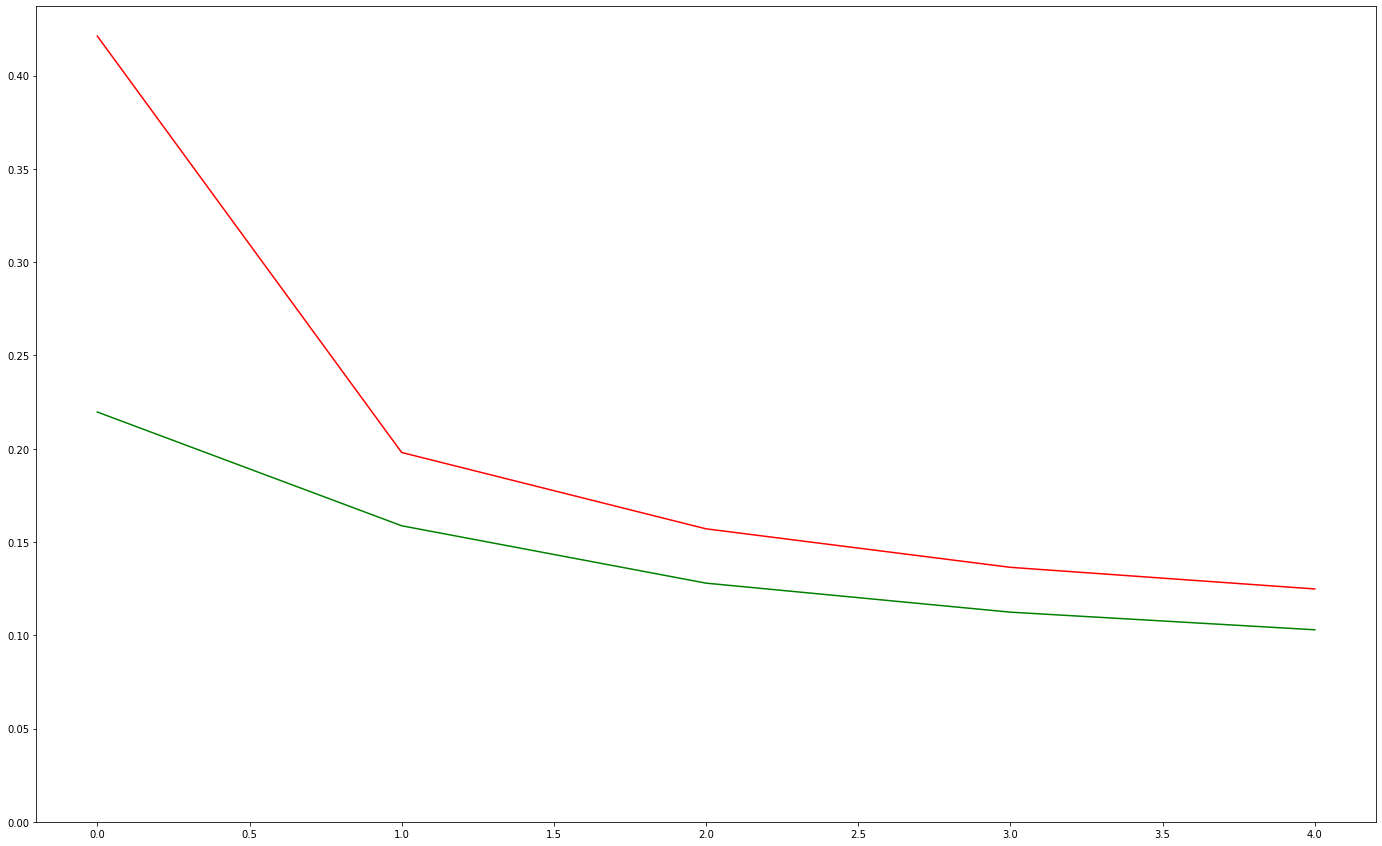

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.140097
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.140538
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.105820
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.187516
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.057868
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.100076
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.110110
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.054740
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.121194
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.044177
Train Epoch: 6 [0/10000 (0%)]	Loss: 0.178172
Train Epoch: 6 [6400/10000 (64%)]	Loss: 0.121348


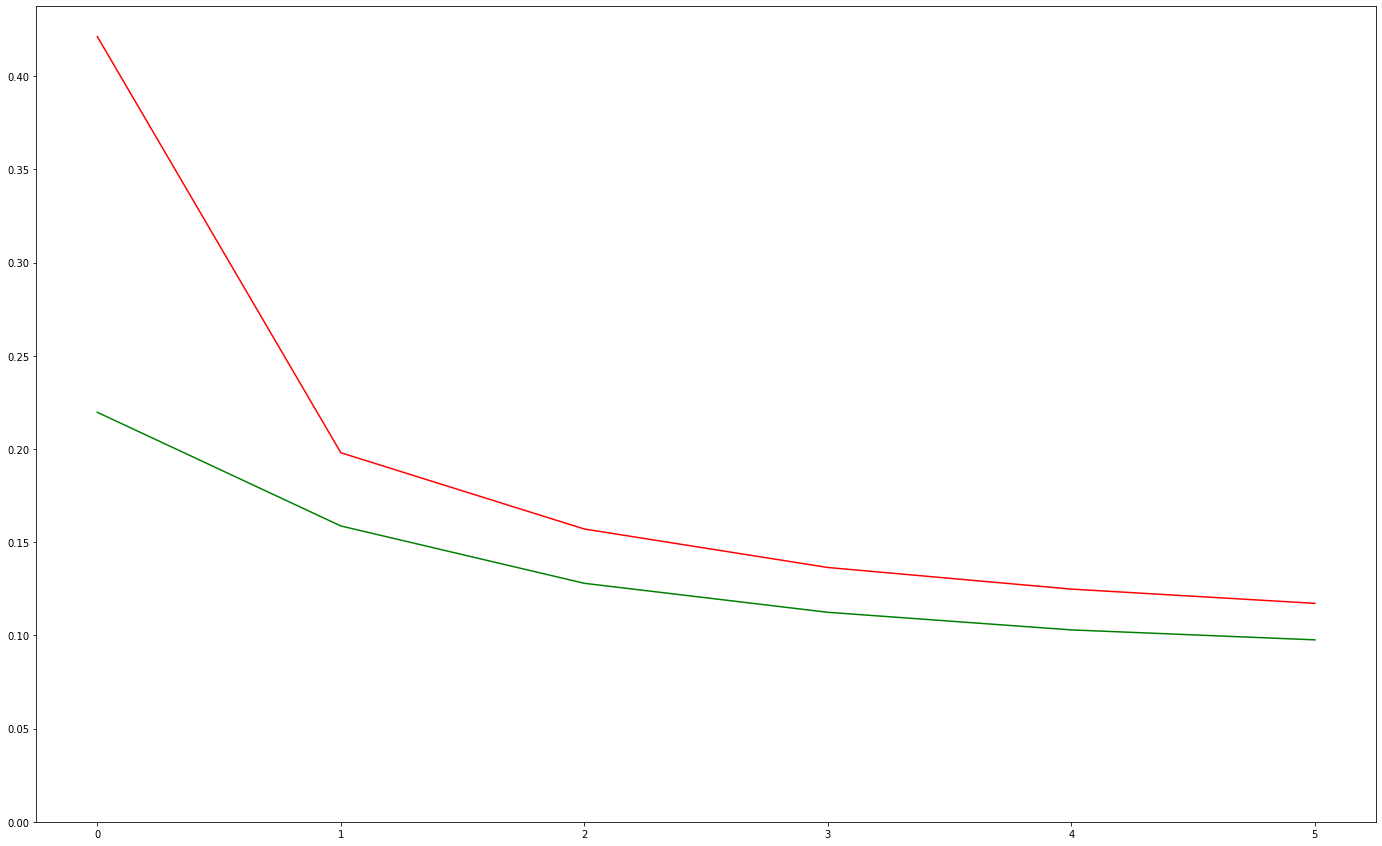

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.050664
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.107476
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.030825
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.098359
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.143507
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.073636
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.090771
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.112949
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.211666
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.039574
Train Epoch: 7 [0/10000 (0%)]	Loss: 0.118344
Train Epoch: 7 [6400/10000 (64%)]	Loss: 0.042449


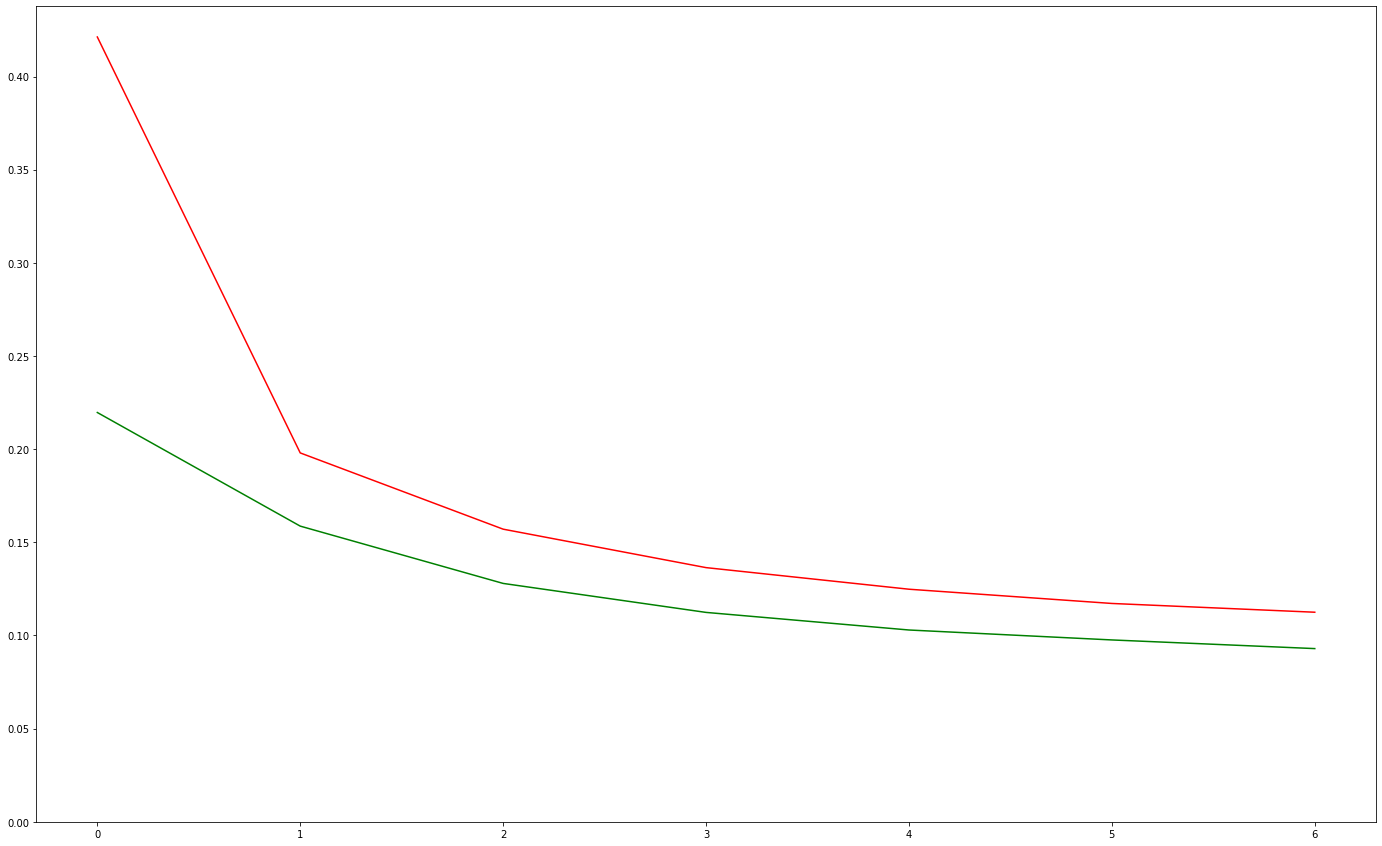

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.071190
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.082787
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.319445
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.095845
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.091862
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.087827
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.044299
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.227411
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.222863
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.205120
Train Epoch: 8 [0/10000 (0%)]	Loss: 0.196955
Train Epoch: 8 [6400/10000 (64%)]	Loss: 0.090176


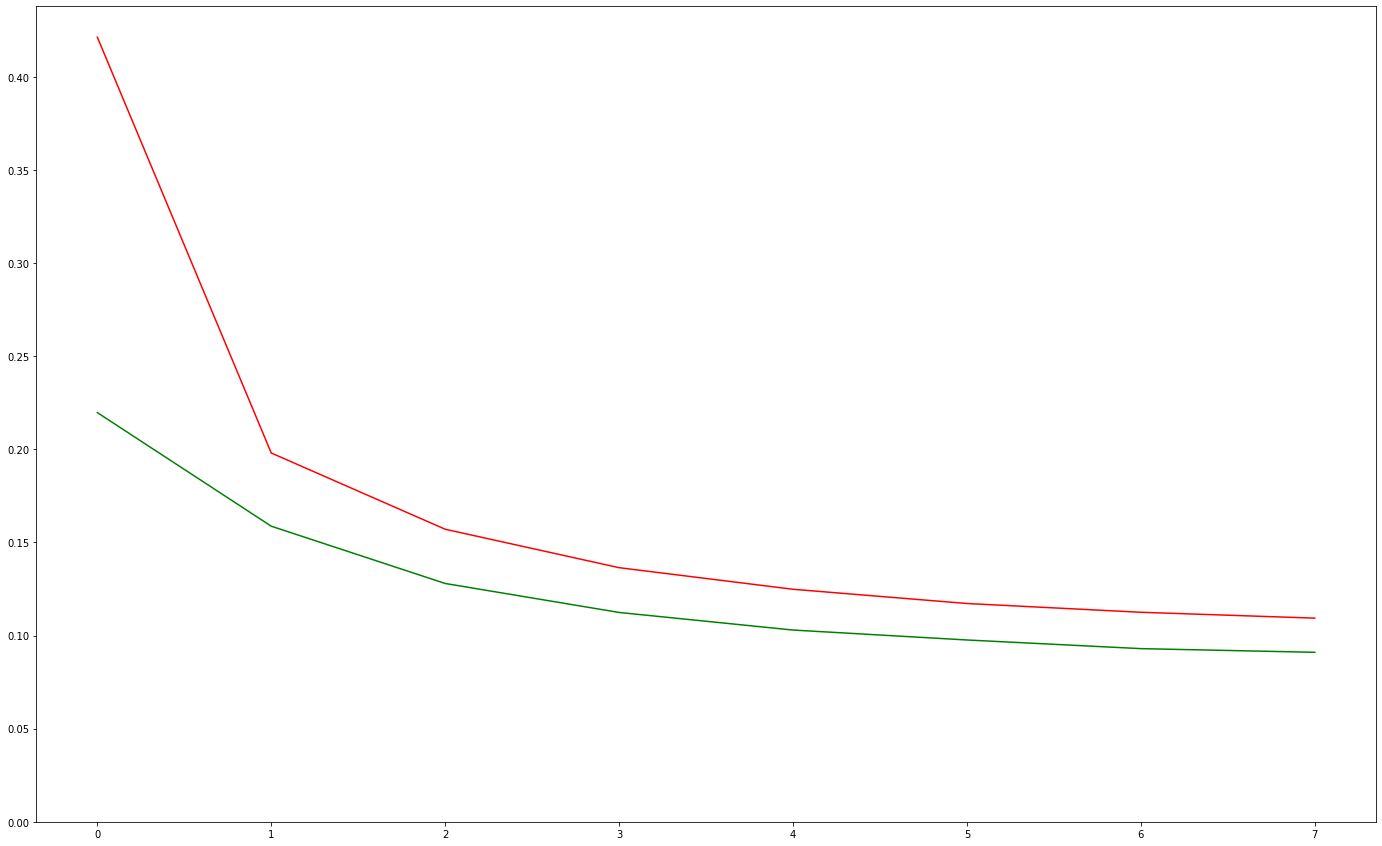

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.158526
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.053148
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.139415
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.180983
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.210114
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.067881
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.267972
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.018800
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.254888
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.204027
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.094662
Train Epoch: 9 [6400/10000 (64%)]	Loss: 0.022626


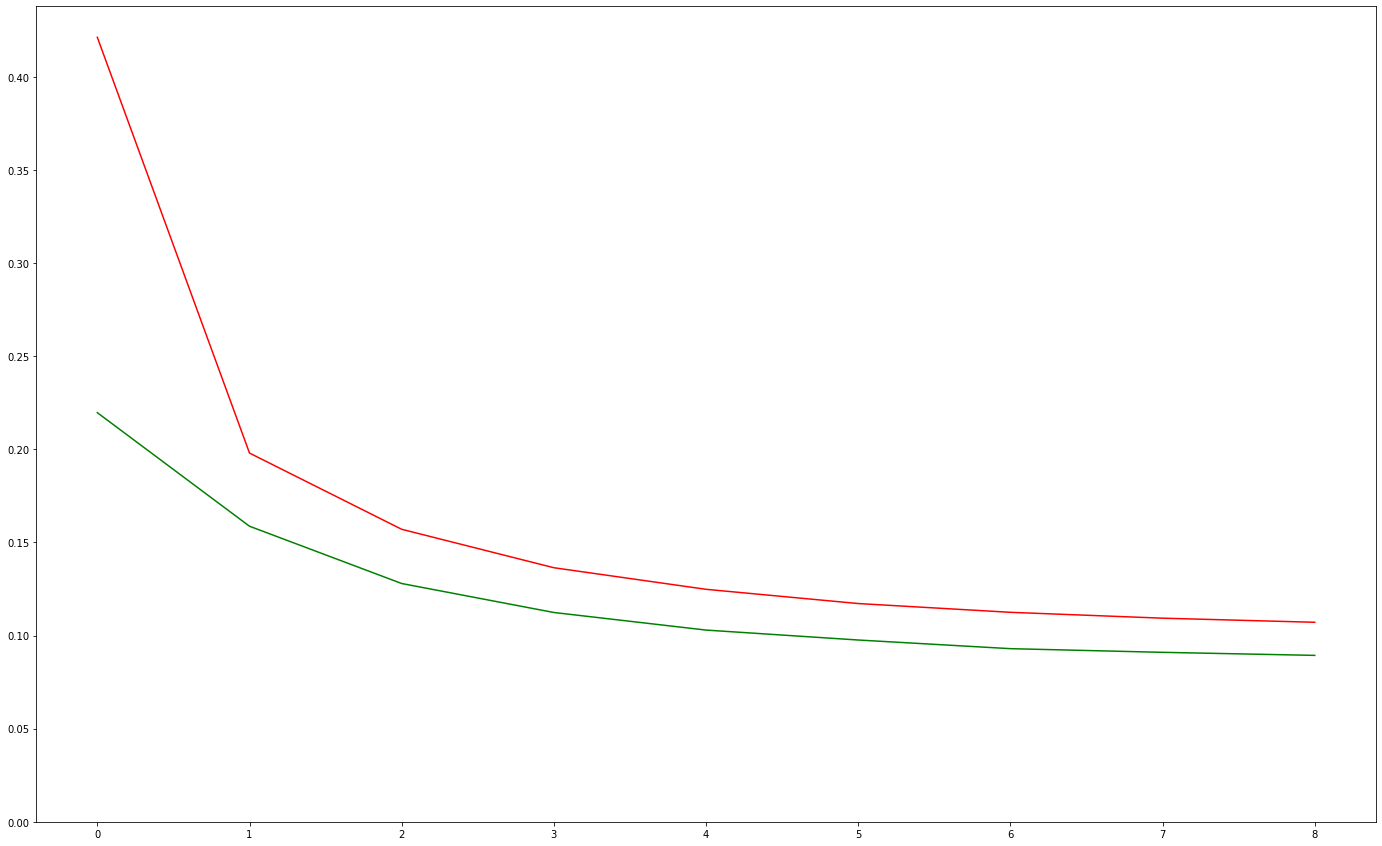

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.129463
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.109064
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.258435
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.072872
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.085409
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.076057
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.057874
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.029320
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.026630
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.091445
Train Epoch: 10 [0/10000 (0%)]	Loss: 0.100436
Train Epoch: 10 [6400/10000 (64%)]	Loss: 0.103099


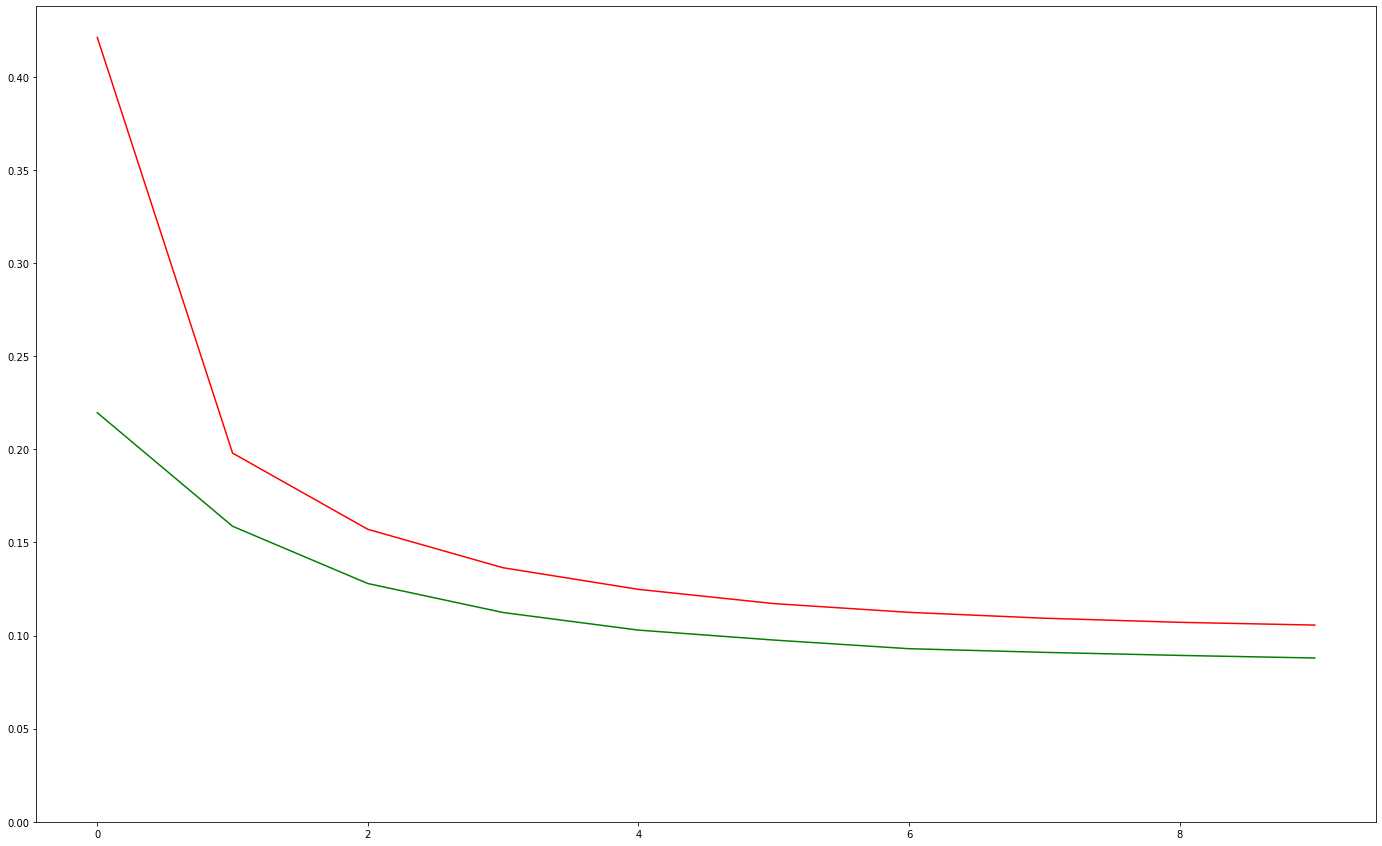

In [6]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

model = Simple_net(100, 10).to(device)
#model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    train(model, device, test_loader, optimizer, epoch, log_interval, test_loss)

    # test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)